In [144]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
from datetime import datetime
df_stream = pd.read_json('C:\\Users\\TKA\Desktop\\MyData\\StreamingHistory0.json')
df_stream.sample(5)

,endTime,artistName,trackName,msPlayed
3793,2021-11-10 11:57,Kolektif İstanbul,Acımadı Yine,198016
2999,2021-09-28 11:08,Joe Dassin,Et si tu n'existais pas,8650
3418,2021-10-19 15:56,Maanam,Krakowski spleen,234241
994,2021-02-16 06:32,MFÖ,Ağlamadan,202066
3862,2021-11-15 05:36,Novus Podcasts,"28 Haziran | 🗞️ YKS, Onur yürüyüşü",1735


In [145]:
df_stream["endTime"] = pd.to_datetime(df_stream["endTime"]) + pd.Timedelta(hours=3)
df_stream["Day"] = pd.to_datetime(df_stream["endTime"], format='%Y-%m-%d %H:%M').dt.day_name()
df_stream["Hour"] = pd.to_datetime(df_stream["endTime"], format='%Y-%m-%d %H:%M').dt.hour
df_stream['Month'] = pd.to_datetime(df_stream["endTime"], format='%Y-%m-%d %H:%M').dt.strftime('%Y-%m')
df_stream["Year"] = pd.to_datetime(df_stream["endTime"], format='%Y-%m-%d %H:%M').dt.year
df_stream['WeekdayOrNot'] = np.where(pd.to_datetime(df_stream["endTime"], format='%Y-%m-%d %H:%M').dt.dayofweek < 5,0,1 )
df_stream["Minutes"] = df_stream["msPlayed"] / 60000
df_stream["Minutes"] = df_stream["Minutes"].round(decimals=1)
df_stream.drop(["msPlayed"],axis=1, inplace=True)
df_stream.iloc[4005:4010]

,endTime,artistName,trackName,Day,Hour,Month,Year,WeekdayOrNot,Minutes
4005,2021-11-26 19:19:00,Metallica,Whiskey In The Jar,Friday,19,2021-11,2021,0,5.1
4006,2021-11-26 19:24:00,Jamie Cullum,High And Dry,Friday,19,2021-11,2021,0,4.9
4007,2021-11-26 19:27:00,Goodbye June,Oh No,Friday,19,2021-11,2021,0,3.7
4008,2021-11-26 19:33:00,Placebo,Every You Every Me,Friday,19,2021-11,2021,0,5.4
4009,2021-11-26 19:37:00,CHVRCHES,Clearest Blue,Friday,19,2021-11,2021,0,3.9


## Create a Session Id with feature engineering

#### We can assume that if there is no song has endTime after 15 minutes, that session is closed.

In [146]:
df_stream["PrevEndTime"] = df_stream["endTime"].shift(1)
df_stream.head()

,endTime,artistName,trackName,Day,Hour,Month,Year,WeekdayOrNot,Minutes,PrevEndTime
0,2020-12-07 22:25:00,DJ Ufuk,Nankör Kedi (REMİX),Monday,22,2020-12,2020,0,0.9,NaT
1,2020-12-08 13:33:00,Kaan Boşnak,Bırakma Kendini,Tuesday,13,2020-12,2020,0,0.0,2020-12-07 22:25:00
2,2020-12-08 13:33:00,Anıl Piyancı,Varsın,Tuesday,13,2020-12,2020,0,0.0,2020-12-08 13:33:00
3,2020-12-08 13:36:00,Kaan Boşnak,Benimle Kayboldun,Tuesday,13,2020-12,2020,0,3.2,2020-12-08 13:33:00
4,2020-12-08 13:40:00,Kaan Boşnak,Seni Buldum Ya,Tuesday,13,2020-12,2020,0,3.9,2020-12-08 13:36:00


In [147]:
df_stream["PrevEndTime"] = df_stream["endTime"].shift(1)
df_stream.loc[0, 'Session_Id'] = 1
for i in range(1, len(df_stream)):   
    if df_stream.loc[i-1, 'endTime'] + pd.Timedelta(minutes=30)  < df_stream.loc[i, 'endTime']  :  
        df_stream.loc[i, "Session_Id"] = df_stream.loc[i-1, 'Session_Id'] + 1
    else:
        df_stream.loc[i, 'Session_Id'] = df_stream.loc[i-1, 'Session_Id']
df_stream.iloc[2212:2216]

,endTime,artistName,trackName,Day,Hour,Month,Year,WeekdayOrNot,Minutes,PrevEndTime,Session_Id
2212,2021-06-07 12:39:00,Måneskin,I WANNA BE YOUR SLAVE,Monday,12,2021-06,2021,0,2.9,2021-06-07 12:36:00,260.0
2213,2021-06-07 12:42:00,Måneskin,ZITTI E BUONI,Monday,12,2021-06,2021,0,3.2,2021-06-07 12:39:00,260.0
2214,2021-06-07 17:16:00,Måneskin,CORALINE,Monday,17,2021-06,2021,0,0.0,2021-06-07 12:42:00,261.0
2215,2021-06-07 17:19:00,Måneskin,CORALINE,Monday,17,2021-06,2021,0,0.2,2021-06-07 17:16:00,261.0


### Session Count

In [149]:
str(df_stream.groupby("Session_Id").agg({"Minutes":"sum"}).count()[0])

'473'

In [150]:
df_stream.endTime.min()

Timestamp('2020-12-07 22:25:00')

In [151]:
str(datetime.strptime(str(df_stream.endTime.min()), '%Y-%m-%d %H:%M:%S').strftime('%d-%b-%Y').upper())

'07-DEC-2020'

### Average Session Length

In [152]:
str(round(df_stream.groupby("Session_Id").agg({"Minutes":"sum"})["Minutes"].mean()))

'26'

### Session Duration Distribution

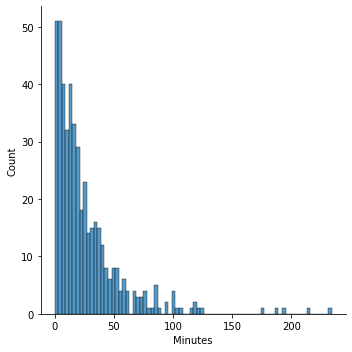

In [153]:
sns.displot(df_stream.groupby("Session_Id").agg({"Minutes":"sum"}), x="Minutes", binwidth=3)

### Session Duration Distribution with Weekday Attribute

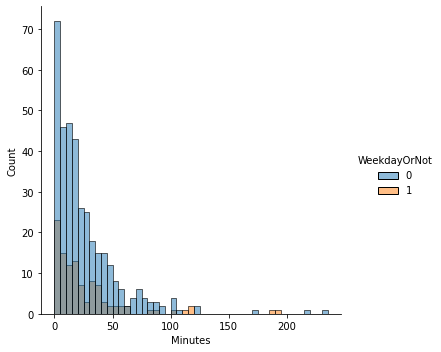

In [154]:
sns.displot(df_stream.groupby(["Session_Id","WeekdayOrNot"]).agg({"Minutes":"sum"}), x="Minutes", binwidth=5, hue="WeekdayOrNot")

## Session Intervals

In [155]:
df_stream_session = df_stream.groupby("Session_Id").agg({"endTime":"max"}).reset_index()
df_stream_session

,Session_Id,endTime
0,1.0,2020-12-07 22:25:00
1,2.0,2020-12-08 13:55:00
2,3.0,2020-12-12 14:11:00
3,4.0,2020-12-13 17:28:00
4,5.0,2020-12-15 14:39:00
...,...,...
468,469.0,2021-12-07 11:55:00
469,470.0,2021-12-07 14:20:00
470,471.0,2021-12-07 15:45:00
471,472.0,2021-12-08 11:49:00


In [156]:
df_stream_session["Interval"] = df_stream_session["endTime"] - df_stream_session["endTime"].shift(1)
df_stream_session["IntervalHour"] = df_stream_session["Interval"].dt.total_seconds() / (60 * 60)
df_stream_session

,Session_Id,endTime,Interval,IntervalHour
0,1.0,2020-12-07 22:25:00,NaT,NaN
1,2.0,2020-12-08 13:55:00,0 days 15:30:00,15.500000
2,3.0,2020-12-12 14:11:00,4 days 00:16:00,96.266667
3,4.0,2020-12-13 17:28:00,1 days 03:17:00,27.283333
4,5.0,2020-12-15 14:39:00,1 days 21:11:00,45.183333
...,...,...,...,...
468,469.0,2021-12-07 11:55:00,0 days 01:05:00,1.083333
469,470.0,2021-12-07 14:20:00,0 days 02:25:00,2.416667
470,471.0,2021-12-07 15:45:00,0 days 01:25:00,1.416667
471,472.0,2021-12-08 11:49:00,0 days 20:04:00,20.066667


In [157]:
df_stream_session.IntervalHour.mean()

18.591278248587574

### Longest Session Id's

In [159]:
int(df_stream.groupby("Session_Id").agg({"Minutes":"sum"}).sort_values(by=["Minutes"], ascending=False).head(1)['Minutes'].values[0])

233

In [160]:
longest_session_time = int(df_stream.groupby("Session_Id").agg({"Minutes":"sum"}).sort_values(by=["Minutes"], ascending=False).head(1)['Minutes'].values[0])
session_id  = df_stream.groupby("Session_Id").agg({"Minutes":"sum"}).sort_values(by=["Minutes"], ascending=False).head(1).reset_index()["Session_Id"]
artist_list = df_stream[df_stream.Session_Id.isin(session_id)].artistName.unique()
print("In the session " + str(int(session_id[0])) + ", you listened " +str(longest_session_time)+ " minutes these artists: " + str(set(artist_list)) )

In the session 455, you listened 233 minutes these artists: {'Imagine Dragons', 'Twenty One Pilots', 'Jamie Cullum', 'Foals', 'Tom Grennan', 'Glass Animals', 'Machine Gun Kelly', 'Faith No More', 'Queen', 'Goodbye June', 'Metallica', 'Owl City', 'Tom Misch', 'alt-J', 'CHVRCHES', 'Placebo', 'Nothing But Thieves', 'The Killers', 'The Last Internationale', 'Pixies', 'Sigrid', 'Frank Carter & The Rattlesnakes', 'Kings of Leon', 'Editors', 'YUNGBLUD', 'Florence + The Machine', 'Black Pumas'}


In [161]:
df_stream.groupby("Session_Id").agg({"Minutes":"sum"}).sort_values(by=["Minutes"], ascending=False).head(1).reset_index()["Session_Id"]

0    455.0
Name: Session_Id, dtype: float64

### Longest Session

In [162]:
df_stream[df_stream.Session_Id == 450]

,endTime,artistName,trackName,Day,Hour,Month,Year,WeekdayOrNot,Minutes,PrevEndTime,Session_Id
3934,2021-11-21 16:06:00,Metallica,Spit Out The Bone,Sunday,16,2021-11,2021,1,7.2,2021-11-20 10:19:00,450.0
3935,2021-11-21 16:10:00,Firewater,Electric City,Sunday,16,2021-11,2021,1,4.6,2021-11-21 16:06:00,450.0
3936,2021-11-21 16:16:00,Ken Hensley,Lady in Black,Sunday,16,2021-11,2021,1,5.6,2021-11-21 16:10:00,450.0
3937,2021-11-21 16:21:00,Kolektif İstanbul,Acımadı Yine,Sunday,16,2021-11,2021,1,4.7,2021-11-21 16:16:00,450.0
3938,2021-11-21 16:24:00,THE ROOP,Discoteque,Sunday,16,2021-11,2021,1,3.0,2021-11-21 16:21:00,450.0
3939,2021-11-21 16:27:00,Elena Tsagrinou,El Diablo,Sunday,16,2021-11,2021,1,3.0,2021-11-21 16:24:00,450.0
3940,2021-11-21 16:31:00,Megadeth,Peace Sells - Remastered,Sunday,16,2021-11,2021,1,4.1,2021-11-21 16:27:00,450.0
3941,2021-11-21 16:34:00,Megadeth,Architecture Of Aggression,Sunday,16,2021-11,2021,1,3.7,2021-11-21 16:31:00,450.0
3942,2021-11-21 16:37:00,Morrissey,I Wish You Lonely,Sunday,16,2021-11,2021,1,3.0,2021-11-21 16:34:00,450.0
3943,2021-11-21 16:42:00,Scala & Kolacny Brothers,Le vent nous portera,Sunday,16,2021-11,2021,1,4.6,2021-11-21 16:37:00,450.0


In [164]:
session_id = df_stream.groupby("Session_Id").agg({"Minutes":"sum"}).sort_values(by=["Minutes"], ascending=False).head(1).reset_index()["Session_Id"]
df_stream[df_stream.Session_Id.isin(session_id)].artistName.unique()

array(['Queen', 'Placebo', 'Machine Gun Kelly', 'alt-J',
       'Twenty One Pilots', 'Goodbye June', 'Florence + The Machine',
       'Black Pumas', 'The Last Internationale', 'The Killers', 'Foals',
       'YUNGBLUD', 'Metallica', 'Jamie Cullum', 'CHVRCHES',
       'Glass Animals', 'Editors', 'Owl City', 'Imagine Dragons',
       'Pixies', 'Nothing But Thieves', 'Tom Grennan',
       'Frank Carter & The Rattlesnakes', 'Sigrid', 'Faith No More',
       'Kings of Leon', 'Tom Misch'], dtype=object)

## Most Listened Songs

In [167]:
df_top_songs = df_stream.groupby(["trackName","artistName"]).agg({"Minutes":"count"}).reset_index()
df_top_songs = df_top_songs.rename(columns= {'trackName':'trackName', 'artistName':'artistName', 'Minutes':'Count'})
df_top_songs = df_top_songs.sort_values("Count", ascending=False).head(5)
df_top_songs

,trackName,artistName,Count
359,Bohemian Rhapsody,Queen,33
349,Blackstar,David Bowie,30
894,I Wish You Lonely,Morrissey,30
167,Aviation,The Last Shadow Puppets,28
1055,La bohème,Charles Aznavour,26


## Most Listened Artists

In [169]:
df_top_artists = df_stream.groupby("artistName").agg({"Minutes":"sum"}).reset_index()
df_top_artists["Minutes"] = df_top_artists["Minutes"].astype(int)
df_top_artists = df_top_artists.sort_values("Minutes", ascending=False).head(5)
df_top_artists

,artistName,Minutes
438,Metallica,779
535,Queen,710
658,The Last Shadow Puppets,573
524,Pink Floyd,434
150,Daft Punk,350


## Most Listened Hours, Days

In [170]:
df_hour = df_stream.groupby("Hour").agg({"Minutes":"sum"}).reset_index()
df_hour["Minutes"] = df_hour["Minutes"].round(decimals=1)
hours = pd.DataFrame(list(range(0,24)))
hours.columns = ["Hour"]
hour_df = hours.merge(df_hour[["Hour","Minutes"]], how='left', on = 'Hour')
hour_df["Minutes"] = hour_df["Minutes"].fillna(0)
hour_df

,Hour,Minutes
0,0,84.3
1,1,16.5
2,2,0.0
3,3,3.6
4,4,0.0
5,5,0.0
6,6,0.0
7,7,162.6
8,8,526.8
9,9,745.9


In [171]:
def draw_peakhour_graph(df,column):
    
    order_list = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    plt.figure(figsize=(14,7))

    plt.title("Minutes Played by " + str(column) , fontsize=25)

    if column == "Day":
        ax = sns.barplot(column,"Minutes", data = df) 
    else:
        ax = sns.barplot(column,"Minutes", data = df) 
    ax.set_xlabel(str(column),fontsize=25)
    ax.set_ylabel("Minutes Played",fontsize=25)
    ax.tick_params(axis='x', which='major', labelsize=20)
    ax.tick_params(axis='y', which='major', labelsize=20)
    
    for bar, label in zip(ax.patches, df['Minutes']):
        x = bar.get_x()
        width = bar.get_width()
        height = bar.get_height()
        ax.text(x+width/2., height + 0.2, label, color="black", fontsize=14 , ha="center") 
   
    plt.show()

C:\Users\TKA\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


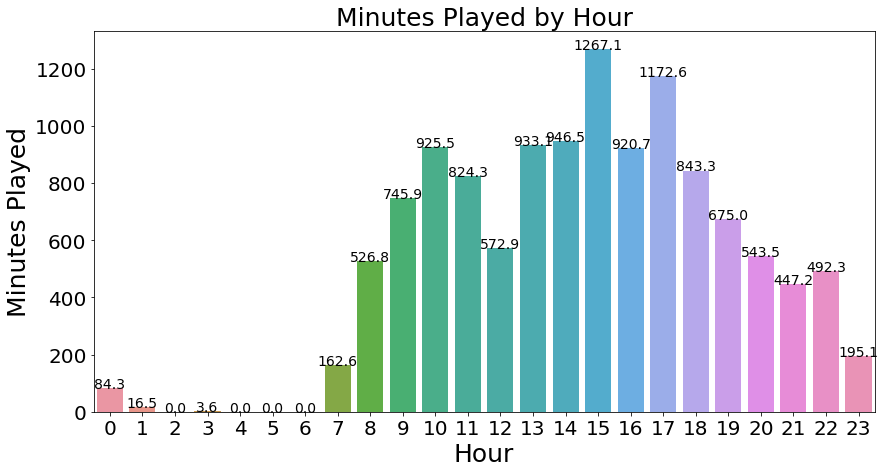

In [172]:
draw_peakhour_graph(hour_df,"Hour")

In [173]:
df_day = df_stream.groupby("Day").agg({"Minutes":"sum"}).reset_index()
df_day["Minutes"] = df_day["Minutes"].round(decimals=1)
df_day['Day'] = pd.Categorical(
    df_day['Day'],  categories=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"], ordered=True
         )
df_day = df_day.sort_values('Day',ascending=True)

C:\Users\TKA\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


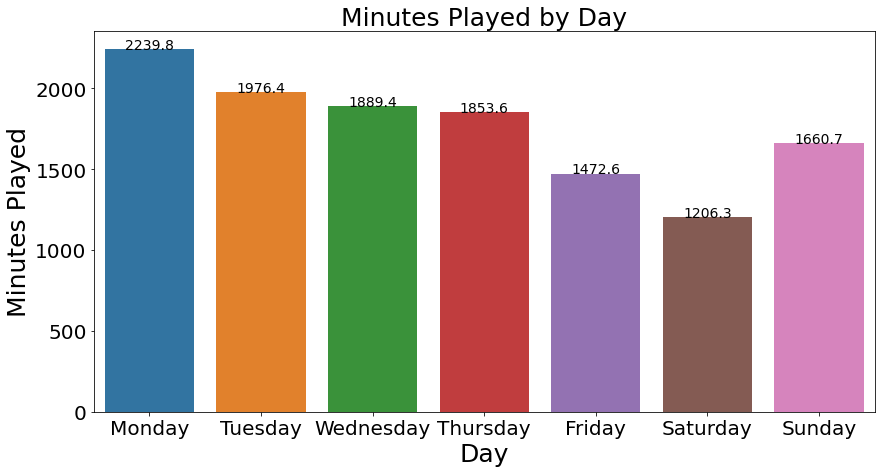

In [174]:
draw_peakhour_graph(df_day,"Day")

C:\Users\TKA\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


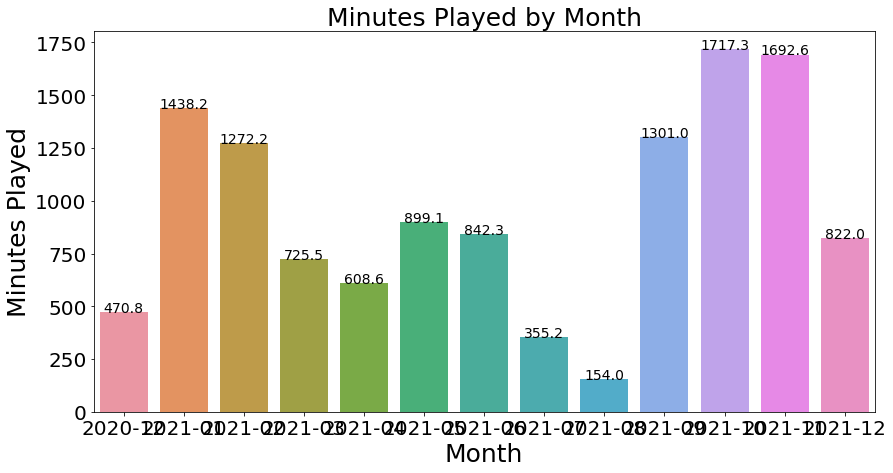

In [175]:
df_month = df_stream.groupby("Month").agg({"Minutes":"sum"}).reset_index()
df_month["Minutes"] = df_month["Minutes"].round(decimals=1)
draw_peakhour_graph(df_month,"Month")

## Most Liked Artist by Month

In [176]:
df_stream.head(5)

,endTime,artistName,trackName,Day,Hour,Month,Year,WeekdayOrNot,Minutes,PrevEndTime,Session_Id
0,2020-12-07 22:25:00,DJ Ufuk,Nankör Kedi (REMİX),Monday,22,2020-12,2020,0,0.9,NaT,1.0
1,2020-12-08 13:33:00,Kaan Boşnak,Bırakma Kendini,Tuesday,13,2020-12,2020,0,0.0,2020-12-07 22:25:00,2.0
2,2020-12-08 13:33:00,Anıl Piyancı,Varsın,Tuesday,13,2020-12,2020,0,0.0,2020-12-08 13:33:00,2.0
3,2020-12-08 13:36:00,Kaan Boşnak,Benimle Kayboldun,Tuesday,13,2020-12,2020,0,3.2,2020-12-08 13:33:00,2.0
4,2020-12-08 13:40:00,Kaan Boşnak,Seni Buldum Ya,Tuesday,13,2020-12,2020,0,3.9,2020-12-08 13:36:00,2.0


In [177]:
data = df_stream.groupby(["Month","artistName"]).agg({"Minutes":"sum"}).reset_index().sort_values(["Month","artistName"],ascending=False)
data["Rank"] = data.groupby("Month").rank(ascending=False, method='first')["Minutes"]
data = data.loc[data.Rank==1]
data

,Month,artistName,Minutes,Rank
1245,2021-12,Twenty One Pilots,278.8,1.0
1136,2021-11,Metallica,227.8,1.0
996,2021-10,Pink Floyd,156.1,1.0
838,2021-09,Serge Gainsbourg,76.6,1.0
708,2021-08,Metallica,100.8,1.0
688,2021-07,Pink Floyd,189.7,1.0
586,2021-06,David Bowie,58.6,1.0
530,2021-05,Queen,150.7,1.0
391,2021-04,Daft Punk,272.5,1.0
360,2021-03,Queen,118.8,1.0


In [178]:
def draw_most_liked_month(df):
    plt.figure(figsize=(14,7))

    plt.title("Most Liked Artist For Monthly Basis",fontsize=20)
    
    ax = sns.barplot('Month',"Minutes", data = data)  

    ax.set_xlabel("Month",fontsize=15)
    ax.set_ylabel("Minutes",fontsize=15)
    ax.tick_params(axis='x', which='major', labelsize=15)
    ax.tick_params(axis='y', which='major', labelsize=15)

    for bar, label in zip(ax.patches, data['artistName'].loc[::-1]):
        x = bar.get_x()
        width = bar.get_width()
        height = bar.get_height()
        ax.text(x+width/2., height + 0.2, label, backgroundcolor="yellow", color="black", fontsize=11 , ha="center") 

    plt.show()

C:\Users\TKA\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


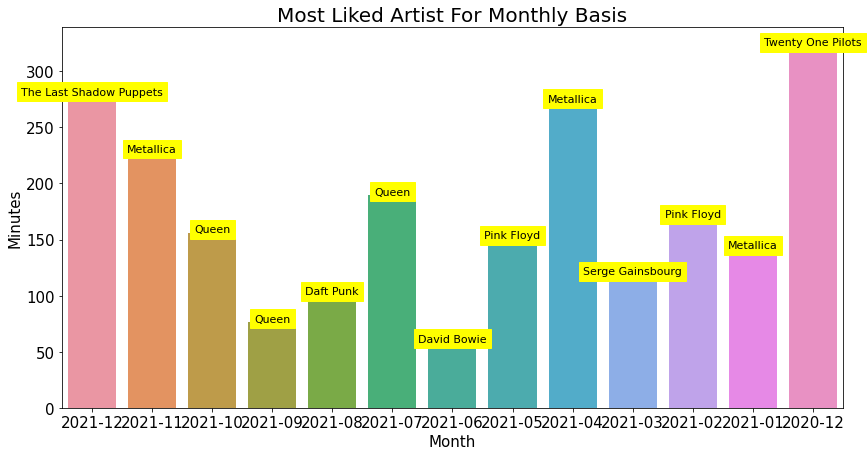

In [179]:
draw_most_liked_month(data)

In [180]:
df_top = df_stream.groupby("artistName").agg({"Minutes":"sum"}).reset_index()
df_top["Minutes"] = df_top["Minutes"].astype(int)
df_top10 = df_top.sort_values("Minutes", ascending=False).head(5)
df_artist1 = df_stream.groupby(["Month","artistName"]).agg({"Minutes":"sum"}).reset_index()
df_artist2 = df_artist1[df_artist1.artistName.isin(df_top10.artistName)]
df_artist2["key"] = df_artist2["Month"] + df_artist2["artistName"]
months = pd.DataFrame(df_artist2["Month"].unique())
artists = pd.DataFrame(df_artist2["artistName"].unique() )
months['key'] = 0
artists['key'] = 0
months_and_artists = months.merge(artists, how='outer', on = 'key')
months_and_artists.drop('key',1, inplace=True)
months_and_artists.columns = ["Month","artistName"]
months_and_artists["key"] = months_and_artists["Month"] + months_and_artists["artistName"]
months_and_artists = pd.merge(months_and_artists, df_artist2[["key","Minutes"]], how='left', on ='key')
months_and_artists.drop('key',1, inplace=True)
months_and_artists["Minutes"] = months_and_artists["Minutes"].fillna(0)
months_and_artists

C:\Users\TKA\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Month,artistName,Minutes
0,2020-12,The Last Shadow Puppets,323.0
1,2020-12,Metallica,0.0
2,2020-12,Pink Floyd,0.0
3,2020-12,Queen,0.0
4,2020-12,Daft Punk,0.0
...,...,...,...
60,2021-12,The Last Shadow Puppets,0.0
61,2021-12,Metallica,202.7
62,2021-12,Pink Floyd,0.0
63,2021-12,Queen,0.0
